In [27]:
import numpy as np
import pandas as pd
import random
from math import sqrt
import matplotlib.pyplot as plt

In [28]:
data = pd.read_csv('insurance.txt')
data.insert(0,'ones',1) # Add a column of ones
data

,ones,age,bmi,children,charges
0,1,19,27.900,0,16884.92400
1,1,18,33.770,1,1725.55230
2,1,28,33.000,3,4449.46200
3,1,33,22.705,0,21984.47061
4,1,32,28.880,0,3866.85520
...,...,...,...,...,...
1333,1,50,30.970,3,10600.54830
1334,1,18,31.920,0,2205.98080
1335,1,18,36.850,0,1629.83350
1336,1,21,25.800,0,2007.94500


In [29]:
def splitData(data):
    msk = np.random.rand(len(data)) < 0.7
    train = data[msk]
    featureTrain = train.iloc[:,0:4].values
    targetTrain = train.iloc[:,4].values
    
    test=data[~msk]
    featureTest = test.iloc[:,0:4].values
    targetTest = test.iloc[:,4].values
    #print(len(train), len(test))
    return featureTrain, featureTest, targetTrain, targetTest

#splitData(data)

In [30]:
def predict_output(feature_matrix, weights):
    # creating the predictions vector
    # display(feature_matrix, weights)
    predictions=np.dot(feature_matrix,weights)
    return(predictions)

In [41]:
def standardize(feature_matrix, target):
  min_array=np.amin(feature_matrix,axis=0)
  max_array=np.amax(feature_matrix,axis=0)
  for i in range(1,feature_matrix.shape[1]):  # standardize features
    for j in range(feature_matrix.shape[0]):
      feature_matrix[j][i]=((feature_matrix[j][i]-min_array[i])/(max_array[i]-min_array[i]))
  targetMin=target.min();
  targetMax=target.max();
  target=(target-target.min())/(target.max()-target.min()) # standardize target
  return (feature_matrix,target,targetMax,targetMin)

**Normal Equations Method**

In [42]:
def normalModel(featureMatrix, target):

    # B = (xTx)^-1.(xTy)
    featureTranspose = np.transpose(featureMatrix)
    featureDot = featureTranspose.dot(featureMatrix)
    temp1 = np.linalg.inv(featureDot)
    temp2 = featureTranspose.dot(target)
    weights = temp1.dot(temp2)

    return weights

In [33]:
def calcNormal(featureTrain, featureTest, targetTrain, targetTest, trainMax, trainMin, testMax, testMin):

    normalWeights = normalModel(featureTrain, targetTrain)  # Calculating weights for the model

    predictionTrain = predict_output(featureTrain, normalWeights)   # Predicting training outputs from model obtained 
    trainingError = np.sqrt(((predictionTrain - targetTrain) ** 2).mean())  # Calculating the RMSE for training data
    trainingError = trainingError*(trainMax - trainMin) + trainMin            #removing standardization

    predictionTest = predict_output(featureTest, normalWeights)     # Predicting training outputs from model obtained 
    testingError = np.sqrt(((predictionTest - targetTest) ** 2).mean()) # Calculating the RMSE for testing data
    testingError = testingError*(testMax - testMin) + testMin            #removing standardization

    return normalWeights, trainingError, testingError

In [51]:

trainingErrors = np.array([]) 
testingErrors = np.array([])
for i in range(20):
    featureTrain, featureTest, targetTrain, targetTest = splitData(data)
    featureTrain, targetTrain, trainMax, trainMin = standardize(featureTrain, targetTrain)
    featureTest, targetTest, testMax, testMin = standardize(featureTest, targetTest)
    # display(featureTrain, featureTest, targetTrain, targetTest)
    model, trainingError, testingError = calcNormal(featureTrain, featureTest, targetTrain, targetTest, trainMax, trainMin, testMax, testMin)
    trainingErrors = np.append(trainingErrors, trainingError)
    testingErrors = np.append(testingErrors, testingError)

# display(model)


In [52]:
print("Minimum Training Error:     \t", trainingErrors.min())
print("Minimum Testing Error:      \t", testingErrors.min())

print("Mean of Training Errors:    \t", trainingErrors.mean())
print("Mean of Testing Errors:     \t", testingErrors.mean())

print("Variance of Training Errors:\t", trainingErrors.var())
print("Variance of Testing Errors: \t", trainingErrors.var())


Minimum Training Error:     	 12109.549352740156
Minimum Testing Error:      	 11546.374560680655
Mean of Training Errors:    	 12496.985802403538
Mean of Testing Errors:     	 12489.6876234537
Variance of Training Errors:	 43863.10612725413
Variance of Testing Errors: 	 43863.10612725413


**Gradient Descent Method**

In [53]:
def feature_derivative(errors, feature):
    # computing derivative
    derivative = 2 *np.dot(errors, feature)
    return(derivative)

In [55]:
def regression_gradient_descent(feature_matrix, output, initial_weights, step_size, max_iters, trainMax, trainMin):
    
    weights = np.array(initial_weights) 
    feature_matrix_old=feature_matrix
    output_old=output
    trainingErrors=np.array([])

    for j in range(max_iters):
        # computing the predictions
        predictions = predict_output(feature_matrix, weights)
        # computing the errors
        errors = predictions - output
        gradient_sum_squares = 0 

        for i in range(len(weights)): # looping over each weight
            # computing the derivative for weight[i]:
            derivative = feature_derivative(errors, feature_matrix[:, i])
            gradient_sum_squares = gradient_sum_squares + (derivative)**2
            #print(weights[i],derivative,step_size)
            weights[i]=weights[i] - (derivative * step_size)

        gradient_magnitude = sqrt(gradient_sum_squares)

        predictionTrain = predict_output(feature_matrix_old, weights)   
        trainingError = np.sqrt(((predictionTrain - output_old) ** 2).mean())
        trainingError = trainingError*(trainMax - trainMin) + trainMin            #removing standardization
        trainingErrors = np.append(trainingErrors, trainingError)
        
        if ((j+1)%(max_iters/10)==0):
          
          print(j+1," : ","Training Error : ",trainingError,)

    return(weights,trainingErrors)

In [56]:
def calcGradientDescent(featureTrain, featureTest, targetTrain, targetTest, trainMax, trainMin, testMax, testMin,step_size, max_iters):

    initial_weights = np.array([0., 0., 0.,0.])

    gradientDescentWeights, epochErrors = regression_gradient_descent(featureTrain, targetTrain,initial_weights, step_size, max_iters, trainMax, trainMin)  # Calculating weights for the model
    #print(gradientDescentWeights)

    predictionTrain = predict_output(featureTrain, gradientDescentWeights)   # Predicting training outputs from model obtained 
    trainingError = np.sqrt(((predictionTrain - targetTrain) ** 2).mean())  # Calculating the RMSE for training data
    trainingError = trainingError*(trainMax - trainMin) + trainMin            #removing standardization

    predictionTest = predict_output(featureTest, gradientDescentWeights)     # Predicting training outputs from model obtained 
    testingError = np.sqrt(((predictionTest - targetTest) ** 2).mean()) # Calculating the RMSE for testing data
    testingError = testingError*(testMax - testMin) + testMin            #removing standardization

    return gradientDescentWeights, trainingError, testingError, epochErrors

In [57]:
trainingErrors = np.array([]) 
testingErrors = np.array([])
step_size=4e-5
max_iters= 10000
for i in range(20):
    print("Model : ",i+1)
    featureTrain, featureTest, targetTrain, targetTest = splitData(data)
    featureTrain, targetTrain, trainMax, trainMin = standardize(featureTrain, targetTrain)
    featureTest, targetTest, testMax, testMin = standardize(featureTest, targetTest)
    #print(testMax,testMin)
    # display(featureTrain, featureTest, targetTrain, targetTest)
    model, trainingError, testingError, epochErrors = calcGradientDescent(featureTrain, featureTest, targetTrain, targetTest, trainMax, trainMin, testMax, testMin, step_size, max_iters)
    trainingErrors = np.append(trainingErrors, trainingError)
    testingErrors = np.append(testingErrors, testingError)

#display(trainingErrors, testingErrors)

Model :  1
1000  :  Training Error :  12378.20237240048
2000  :  Training Error :  12374.874040533132
3000  :  Training Error :  12374.77132578099
4000  :  Training Error :  12374.768151750339
5000  :  Training Error :  12374.768053668186
6000  :  Training Error :  12374.768050637304
7000  :  Training Error :  12374.768050543644
8000  :  Training Error :  12374.768050540752
9000  :  Training Error :  12374.768050540662
10000  :  Training Error :  12374.768050540659
Model :  2
1000  :  Training Error :  12629.126640745262
2000  :  Training Error :  12625.239847702112
3000  :  Training Error :  12625.116063568503
4000  :  Training Error :  12625.112119817595
5000  :  Training Error :  12625.11199417049
6000  :  Training Error :  12625.1119901674
7000  :  Training Error :  12625.11199003986
8000  :  Training Error :  12625.111990035799
9000  :  Training Error :  12625.11199003567
10000  :  Training Error :  12625.111990035664
Model :  3
1000  :  Training Error :  12382.033921587683
2000  

In [58]:
print("Minimum Training Error:     \t", trainingErrors.min())
print("Minimum Testing Error:      \t", testingErrors.min())

print("Mean of Training Errors:    \t", trainingErrors.mean())
print("Mean of Testing Errors:     \t", testingErrors.mean())

print("Variance of Training Errors:\t", trainingErrors.var())
print("Variance of Testing Errors: \t", trainingErrors.var())


Minimum Training Error:     	 12036.574877109995
Minimum Testing Error:      	 12023.306834382267
Mean of Training Errors:    	 12411.510084589598
Mean of Testing Errors:     	 12699.125344332648
Variance of Training Errors:	 27690.730405271228
Variance of Testing Errors: 	 27690.730405271228


**Stochastic Gradient Descent Method**

In [59]:
def stochastic_gradient_descent(feature_matrix, output, initial_weights, step_size, max_iter, batch_size, trainMax, trainMin):
  converged = False
  weights = np.array(initial_weights) 

  feature_matrix_old=feature_matrix
  output_old=output

  # Shuffling the data before starting
  np.random.seed(seed=1) 
  permutation = np.random.permutation(len(feature_matrix))
  feature_matrix = feature_matrix[permutation,:]
  output = output[permutation]

  i=0
  trainingErrors = np.array([]) 
  #print(max_iter)

  for k in range(max_iter):
    # computing the predictions
    predictions = predict_output(feature_matrix[i:i+batch_size,:], weights)
    # computing the errors
    errors = predictions - output[i:i+batch_size]
    gradient_sum_squares = 0 

    for j in range(len(weights)): # looping over each weight
        # computing the derivative for weight[i]:
        derivative = feature_derivative(errors, feature_matrix[i:i+batch_size, j])
        gradient_sum_squares = gradient_sum_squares + (derivative)**2
        weights[j]=weights[j] - ((step_size*derivative) / batch_size)
    
    gradient_magnitude = sqrt(gradient_sum_squares)
    #print(k)

    predictionTrain = predict_output(feature_matrix_old, weights)   
    trainingError = np.sqrt(((predictionTrain - output_old) ** 2).mean())
    trainingError = trainingError*(trainMax - trainMin) + trainMin            #removing standardization
    trainingErrors = np.append(trainingErrors, trainingError)
    
    if (k+1)%(max_iter/10)==0:
      #print(k)
      
      print(k+1," : ", "Training Error : ",trainingError)
            
    # if we made a complete pass over data, we shuffle and restart
    i += batch_size
    if i+batch_size > len(feature_matrix):
        permutation = np.random.permutation(len(feature_matrix))
        feature_matrix = feature_matrix[permutation,:]
        output = output[permutation]
        i = 0

  return(weights,trainingErrors)

In [60]:
def calcStochasticGradientDescent(featureTrain, featureTest, targetTrain, targetTest, trainMax, trainMin, testMax, testMin, step_size, max_iters, batchSize):

    initial_weights = np.array([0., 0., 0.,0.])

    stochasticGradientDescentWeights, epochErrors = stochastic_gradient_descent(featureTrain, targetTrain,initial_weights, step_size, max_iters, batchSize, trainMax, trainMin)  # Calculating weights for the model
    #print(stochasticGradientDescentWeights)

    predictionTrain = predict_output(featureTrain, stochasticGradientDescentWeights)   # Predicting training outputs from model obtained 
    trainingError = np.sqrt(((predictionTrain - targetTrain) ** 2).mean())  # Calculating the RMSE for training data
    trainingError = trainingError*(trainMax - trainMin) + trainMin            #removing standardization

    predictionTest = predict_output(featureTest, stochasticGradientDescentWeights)     # Predicting training outputs from model obtained 
    testingError = np.sqrt(((predictionTest - targetTest) ** 2).mean()) # Calculating the RMSE for testing data
    testingError = testingError*(testMax - testMin) + testMin            #removing standardization

  

    return stochasticGradientDescentWeights, trainingError, testingError, epochErrors

In [65]:
trainingErrors = np.array([]) 
testingErrors = np.array([])
step_size = 4e-5
max_iters= 10000
batchSize= 1
for i in range(20):
    print("Model : ", i+1)
    featureTrain, featureTest, targetTrain, targetTest = splitData(data)
    featureTrain, targetTrain, trainMax, trainMin = standardize(featureTrain, targetTrain)
    featureTest, targetTest, testMax, testMin = standardize(featureTest, targetTest)
    #print(testMax,testMin)
    # display(featureTrain, featureTest, targetTrain, targetTest)
    model, trainingError, testingError, epochErrors = calcStochasticGradientDescent(featureTrain, featureTest, targetTrain, targetTest, trainMax, trainMin, testMax, testMin, step_size, max_iters, batchSize)
    trainingErrors = np.append(trainingErrors, trainingError)
    testingErrors = np.append(testingErrors, testingError)

#display(trainingErrors, testingErrors)

Model :  1
1000  :  Training Error :  17367.12959462725
2000  :  Training Error :  16555.801874916066
3000  :  Training Error :  15859.99626011759
4000  :  Training Error :  15290.187939657575
5000  :  Training Error :  14822.441344046343
6000  :  Training Error :  14429.604812896105
7000  :  Training Error :  14122.086236726449
8000  :  Training Error :  13865.822185811609
9000  :  Training Error :  13665.172624763742
10000  :  Training Error :  13501.639960642442
Model :  2
1000  :  Training Error :  17655.143024717756
2000  :  Training Error :  16822.87552275866
3000  :  Training Error :  16174.8833345621
4000  :  Training Error :  15604.918567480156
5000  :  Training Error :  15109.810173562473
6000  :  Training Error :  14759.652650948226
7000  :  Training Error :  14418.715996385912
8000  :  Training Error :  14166.947976469692
9000  :  Training Error :  13965.827897605477
10000  :  Training Error :  13802.34837816008
Model :  3
1000  :  Training Error :  17080.401111691557
2000 

In [66]:
print("Minimum Training Error:     \t", trainingErrors.min())
print("Minimum Testing Error:      \t", testingErrors.min())

print("Mean of Training Errors:    \t", trainingErrors.mean())
print("Mean of Testing Errors:     \t", testingErrors.mean())

print("Variance of Training Errors:\t", trainingErrors.var())
print("Variance of Testing Errors: \t", trainingErrors.var())


Minimum Training Error:     	 13264.561792512557
Minimum Testing Error:      	 12686.647800639044
Mean of Training Errors:    	 13418.395325077683
Mean of Testing Errors:     	 13608.653210230917
Variance of Training Errors:	 11060.067955857541
Variance of Testing Errors: 	 11060.067955857541


**Plotting Error vs Epochs for various learning rates**

Learning rate : 1e-07
Stochastic Gradient Descent
10000  :  Training Error :  16188.508498539246
20000  :  Training Error :  14815.392669517078
30000  :  Training Error :  13977.161801836362
40000  :  Training Error :  13485.124635159002
50000  :  Training Error :  13197.420419887421
60000  :  Training Error :  13029.547983434037
70000  :  Training Error :  12931.159698195595
80000  :  Training Error :  12872.819465874258
90000  :  Training Error :  12838.012813838628
100000  :  Training Error :  12814.85069703896
Gradient Descent
10000  :  Training Error :  12508.380617707004
20000  :  Training Error :  12508.36715958529
30000  :  Training Error :  12508.367158221416
40000  :  Training Error :  12508.367158221277
50000  :  Training Error :  12508.367158221277
60000  :  Training Error :  12508.367158221277
70000  :  Training Error :  12508.367158221277
80000  :  Training Error :  12508.367158221277
90000  :  Training Error :  12508.367158221277
100000  :  Training Error :  12508.367158

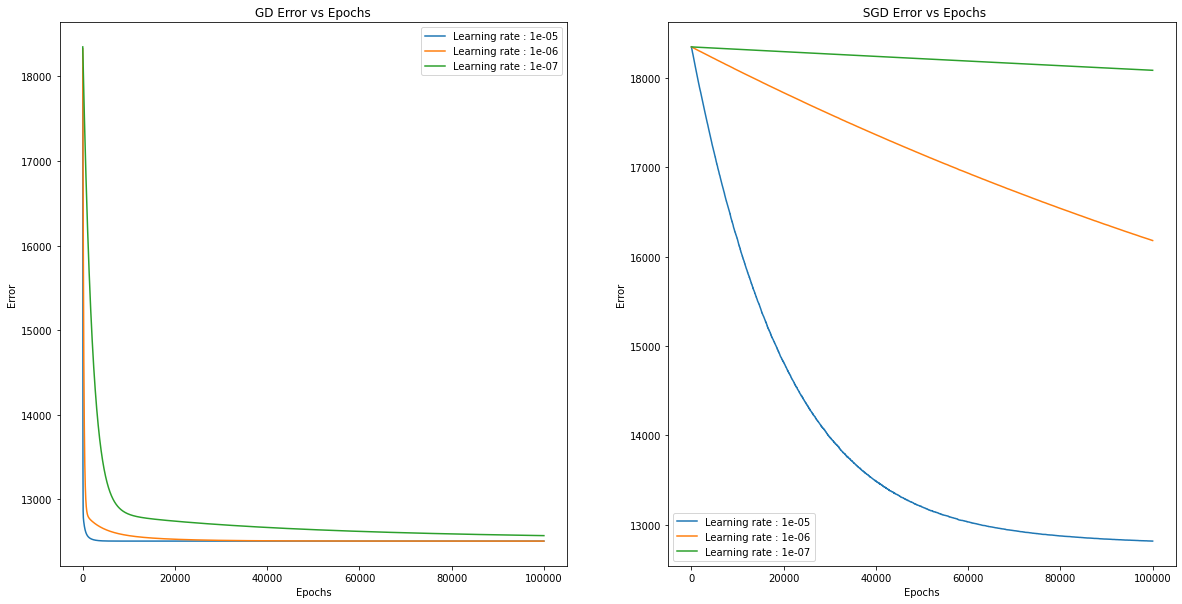

In [63]:
learning_rates = np.array([1e-5,1e-6,1e-7])

max_iters=100000
batch_size=1

fig, (gd, sgd) = plt.subplots(1, 2,figsize=(20,10))
x = np.linspace(0, max_iters, max_iters)
sgd.set_xlabel('Epochs')  # Add an x-label to the axes.
sgd.set_ylabel('Error')  # Add a y-label to the axes.
sgd.set_title(" SGD Error vs Epochs")  # Add a title to the axes.

gd.set_xlabel('Epochs')  # Add an x-label to the axes.
gd.set_ylabel('Error')  # Add a y-label to the axes.
gd.set_title("GD Error vs Epochs")  # Add a title to the axes.

featureTrain, featureTest, targetTrain, targetTest = splitData(data)
featureTrain, targetTrain, trainMax, trainMin = standardize(featureTrain, targetTrain)
featureTest, targetTest, testMax, testMin = standardize(featureTest, targetTest)



for i in learning_rates:
  #print(i)
  print(learningType)
  print("Stochastic Gradient Descent")
  model, trainingError, testingError, epochErrors = calcStochasticGradientDescent(featureTrain, featureTest, targetTrain, targetTest, trainMax, trainMin, testMax, testMin, i, max_iters, batch_size)
  learningType = "Learning rate : " + str(i)
  
  
  sgd.plot(x, epochErrors, label=learningType)
  print("Gradient Descent")
  model, trainingError, testingError, epochErrors = calcGradientDescent(featureTrain, featureTest, targetTrain, targetTest, trainMax, trainMin, testMax, testMin, i, max_iters)
  gd.plot(x, epochErrors, label=learningType)

sgd.legend()
gd.legend()
